# Section 4.4 — Interpreting linear models

This notebook contains the code examples from [Section 4.4 Interpreting linear models]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (8, 6)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/interpreting"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

In [4]:
import statsmodels.formula.api as smf

In [5]:
# TODO: move to Sec 4.3
# Model fit diagnostics and plots
# influence = fit1.get_influence()
# influence.summary_frame()

# resid_studentized = influence.resid_studentized_internal
# resid_studentized

# fit1.outlier_test()
# import statsmodels.api as sm
# sm.graphics.influence_plot(fit1, criterion="cooks");
# sm.graphics.plot_ccpr(fit1, "effort");
# sm.graphics.plot_regress_exog(fit1, "effort");

In [6]:
students = pd.read_csv("../datasets/students.csv")

model1 = smf.ols('score ~ 1 + effort', data=students)
fit1 = model1.fit()

# the coefficients of the best-fit line
fit1.params

Intercept    32.465809
effort        4.504850
dtype: float64

In [7]:
fit1.rsquared, fit1.rsquared_adj

(0.7734103402591798, 0.7559803664329628)

In [8]:
# Explained sum of squares
fit1.ess

1078.2917900307098

In [9]:
fit1.ssr / 15

21.060813997952703

In [10]:
fit1.fittedvalues
# ALT. 
# fit1.predict(students["effort"])

0     81.838969
1     71.612959
2     71.207522
3     68.144224
4     77.063828
5     81.118193
6     67.648690
7     73.595093
8     55.936080
9     67.198205
10    76.703440
11    84.406734
12    64.450247
13    61.251803
14    86.524013
dtype: float64

### Metrics 

In [11]:
from sklearn import metrics
scores = students["score"].values
scoreshat = fit1.fittedvalues.values
ybar = np.mean(scores)


# TSS = Total Sum of Squares
tss = sum( (scores-ybar)**2 ) 
# fit1.centered_tss, tss

# SSR = Sum of Squares Residuals
# ssr = sum( (scores-scoreshat)**2 )
# ssr, fit1.ssr

# ESS = Explained Sum of Squares
# ess = sum( (scoreshat-ybar)**2 ) 
# fit1.ess, ess

# R^2
# metrics.r2_score(scores, scoreshat), fit1.rsquared, 1-fit1.ssr/tss, fit1.ess/tss

# MSE
# metrics.mean_squared_error(scores, scoreshat), fit1.ssr/15

# RMSE
# metrics.root_mean_squared_error(scores, scoreshat), np.sqrt(fit1.ssr/15)

# MAPE
# metrics.mean_absolute_percentage_error(scores, scoreshat)

# MAE
# metrics.mean_absolute_error(scores, scoreshat)

# Mean squared error the model
# The explained sum of squares divided by the model degrees of freedom
# fit1.mse_model, fit1.ess/1

# Mean squared error of the residuals
# The sum of squared residuals divided by the residual degrees of freedom.
# fit1.mse_resid, fit1.ssr/(15-2)

# Total mean squared error
# The uncentered total sum of squares divided by the number of observations.
# fit1.mse_total, tss/(15-1)

## Confidence intervals

In [12]:
# estimated parameters
fit1.params

Intercept    32.465809
effort        4.504850
dtype: float64

In [13]:
# standard errors
fit1.bse

Intercept    6.155051
effort       0.676276
dtype: float64

## Hypothesis testing

In [14]:
fit1.tvalues

Intercept    5.274661
effort       6.661264
dtype: float64

In [15]:
fit1.df_resid

13.0

In [16]:
fit1.pvalues

Intercept    0.000150
effort       0.000016
dtype: float64

In [17]:
# to reproduce `effort` p-value
# from scipy.stats import t as tdist
# 2*(1-tdist(df=fit1.df_resid).cdf(fit1.tvalues["effort"]))

## Prediction

In [67]:
new_data = {"effort": 7}
fit1.predict(new_data)

0    63.999762
dtype: float64

In [68]:
pred_score = fit1.get_prediction(new_data)


In [69]:
# observation  +  90% CI
pred_score.predicted, pred_score.se_obs, pred_score.conf_int(obs=True, alpha=0.1)

(array([63.99976171]),
 array([5.25168079]),
 array([[54.69938482, 73.30013861]]))

In [70]:
# # ALT.
# from scipy.stats import t as tdist
# obs_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_obs)
# obs_dist.ppf(0.05), obs_dist.ppf(0.95)

In [71]:
pred_score.predicted_mean, pred_score.se_mean, pred_score.conf_int(obs=False, alpha=0.1)

(array([63.99976171]),
 array([1.81085943]),
 array([[60.79285027, 67.20667315]]))

In [72]:
# # ALT.
# from scipy.stats import t as tdist
# mean_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_mean)
# mean_dist.ppf(0.05), mean_dist.ppf(0.95)

In [73]:
pred_score.predicted, pred_score.conf_int(alpha=0.1, obs=True)

(array([63.99976171]), array([[54.69938482, 73.30013861]]))

In [74]:
tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_mean).interval(0.1)

(array([63.7677199]), array([64.23180352]))

### Sheffé bands (several different ways)

Text(0, 0.5, 'Y')

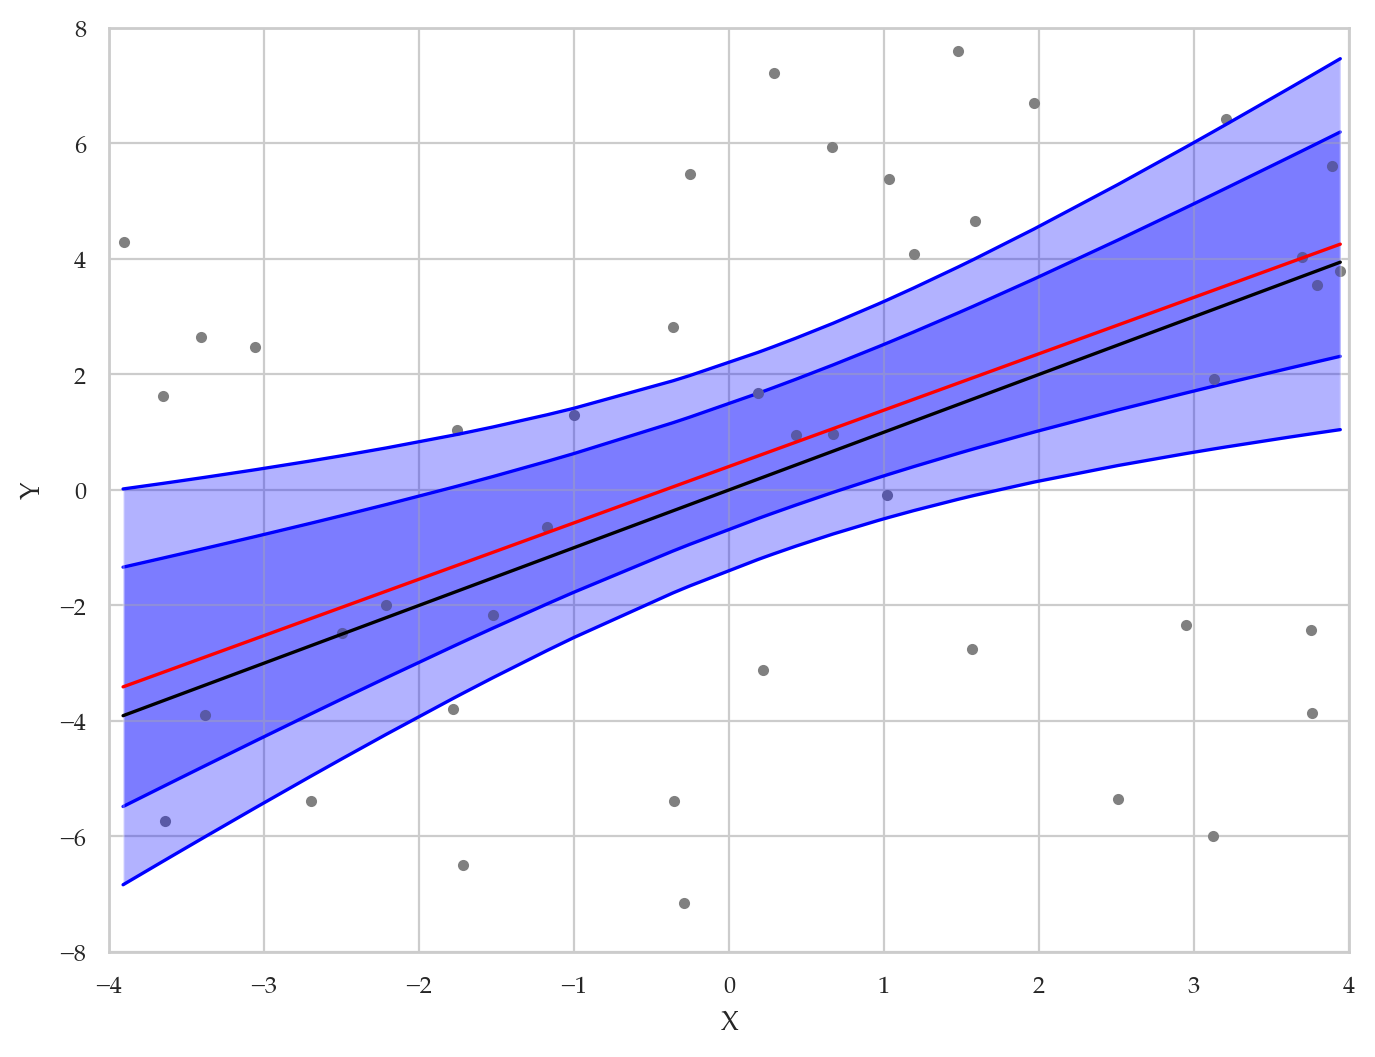

In [75]:
# via https://stackoverflow.com/a/26672416/127114
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 50

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,2))
X[:,1] = XV

## True coefficients.
beta = np.array([0, 1.], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the intervals.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)
QF_2 = sp.fdtri(X.shape[1], n-X.shape[1], 0.68)

## The lower and upper bounds of the Scheffe band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D
D_2 = s*np.sqrt(X.shape[1]*QF_2*V)
LB_2,UB_2 = Yhat-D_2,Yhat+D_2


## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
# plt.hold(True)
a = plt.plot(XV, EY, '-', color='black', zorder = 4)

plt.fill_between(XV, LB_2, UB_2, where = UB_2 >= LB_2, facecolor='blue', alpha= 0.3, zorder = 0)
b = plt.plot(XV, LB_2, '-', color='blue', zorder=1)
plt.plot(XV, UB_2, '-', color='blue', zorder=1)

plt.fill_between(XV, LB, UB, where = UB >= LB, facecolor='blue', alpha= 0.3, zorder = 2)
b = plt.plot(XV, LB, '-', color='blue', zorder=3)
plt.plot(XV, UB, '-', color='blue', zorder=3)

d = plt.plot(XV, Yhat, '-', color='red',zorder=4)

plt.ylim([-8,8])
plt.xlim([-4,4])

plt.xlabel("X")
plt.ylabel("Y")

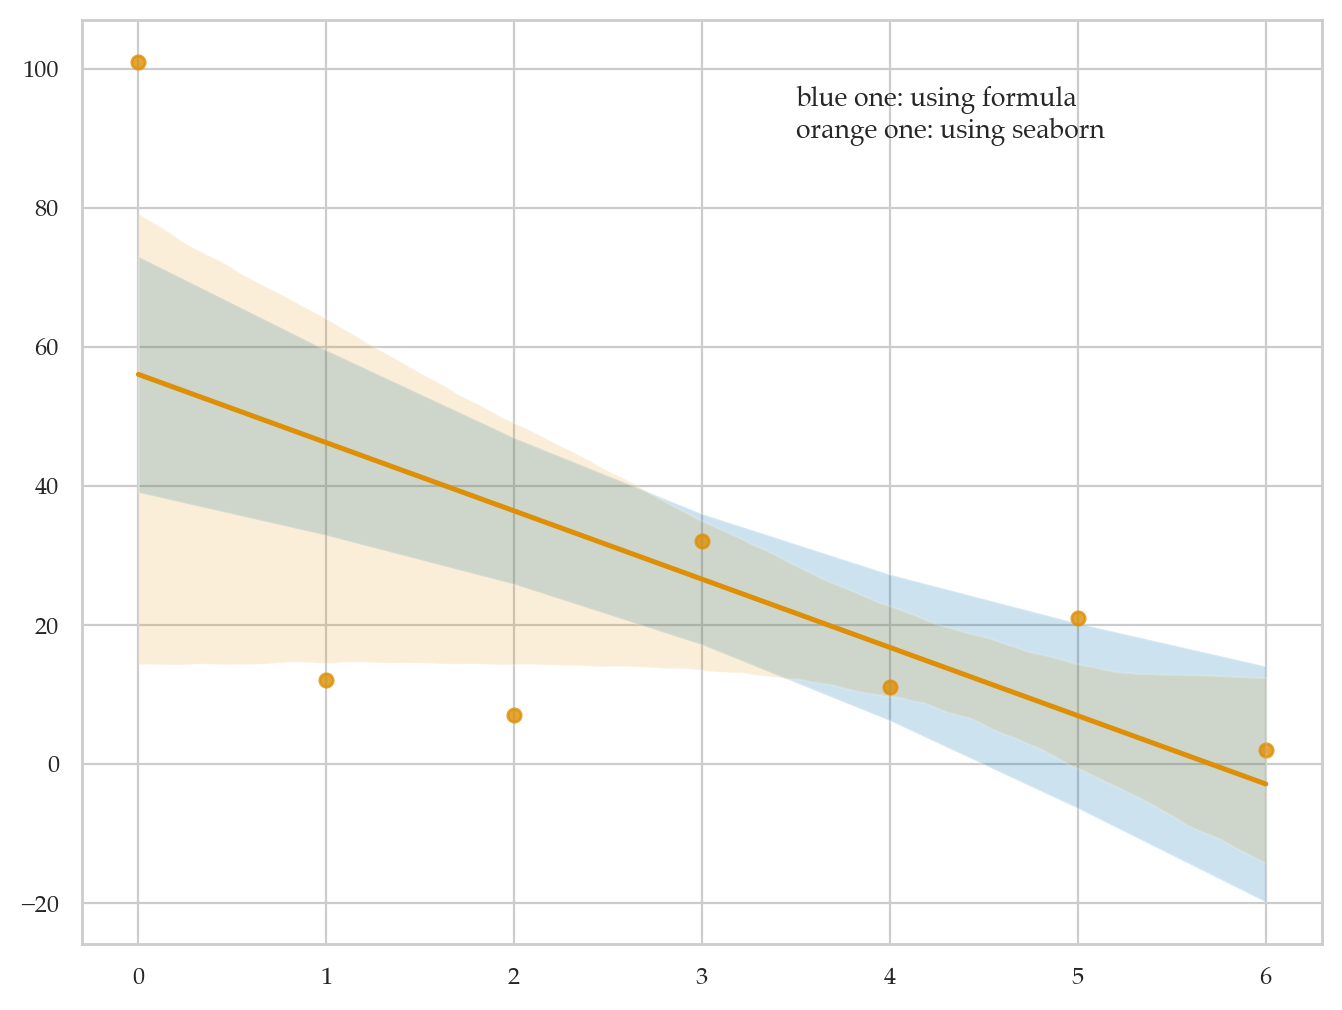

In [20]:
# via https://discuss.python.org/t/whats-the-meaning-of-this-confidence-bands/14445/9
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = np.arange(7)
y = np.array([101,12,7,32,11,21,2])
n = x.size

# calculate interval manually using the formula
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = (y-y_est).std() * np.sqrt(1/n + (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()

# plot manually calculated interval (std interval) --- the blue one
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

# plot seaborn calculated interval (std interval, i.e. when ci=68.27) --- the orange one
sns.regplot(x=x, y=y, ci=68.27)

plt.text(3.5,90,'blue one: using formula\norange one: using seaborn')
plt.show()

Optimal Values
a: 0.036141582292222356
b: -0.5735680960487426
R^2: 0.5278048667629538
Uncertainty
a: 0.0361+/-0.0035
b: -0.57+/-0.07


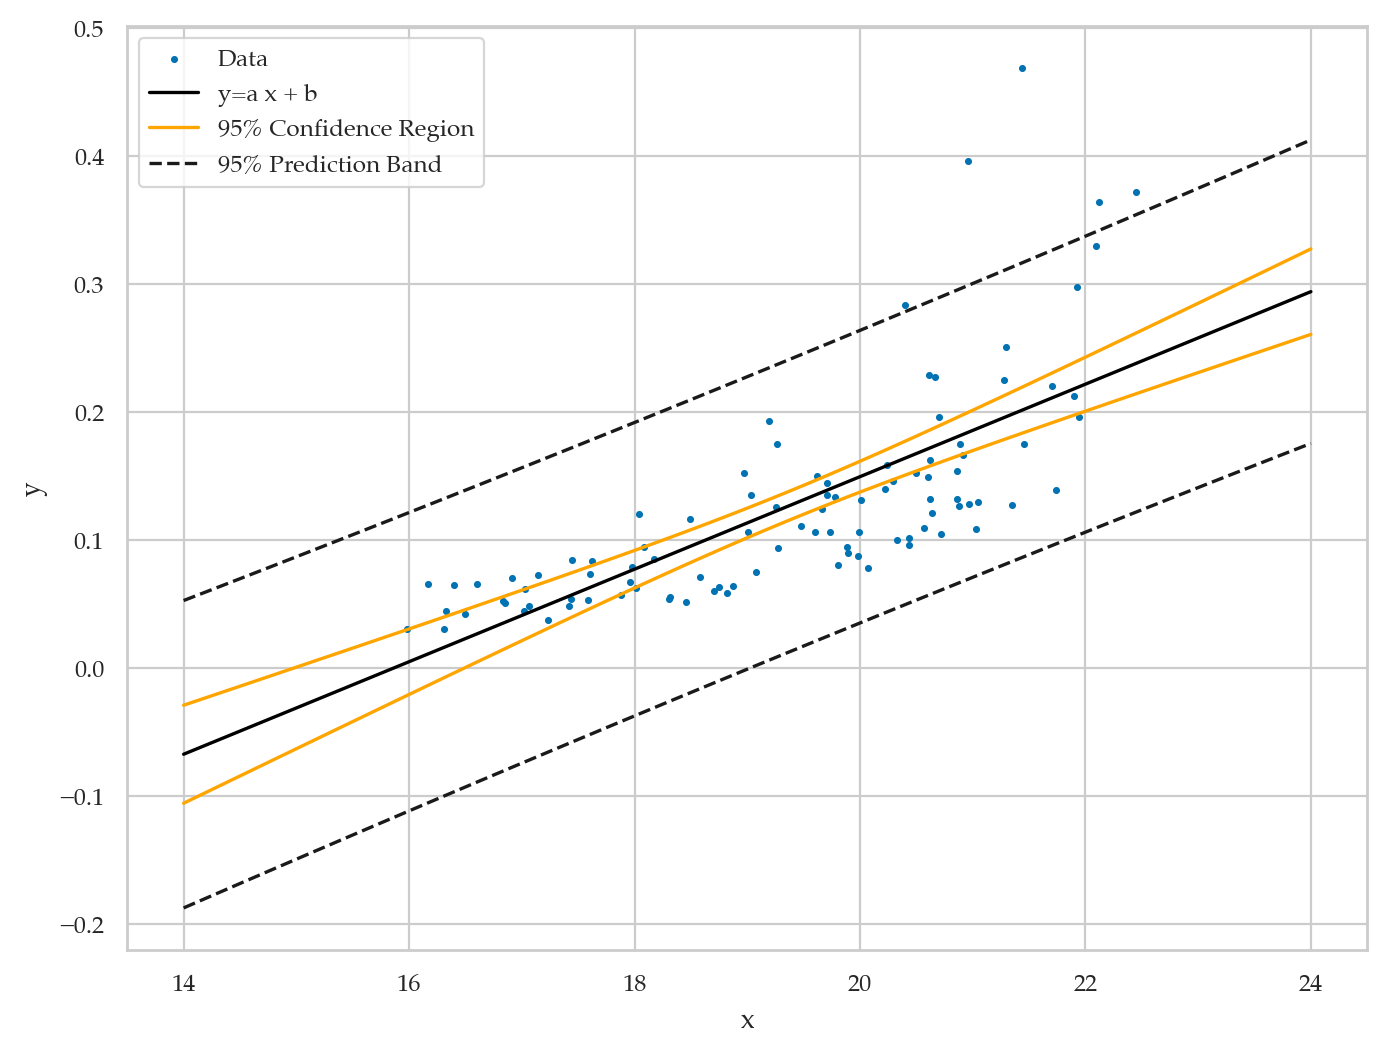

In [21]:
# via https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
# see also https://www.youtube.com/watch?v=r4pgGD1kpYM
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

# import data
url = 'http://apmonitor.com/che263/uploads/Main/stats_data.txt'
data = pd.read_csv(url)
x = data['x'].values
y = data['y'].values
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))

# plot data
plt.scatter(x, y, s=3, label='Data')

# calculate regression confidence interval
px = np.linspace(14, 24, 100)
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x, y, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='y=a x + b')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='orange',\
         label='95% Confidence Region')
plt.plot(px, nom + 1.96 * std, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

Text(0, 0.5, 'Y')

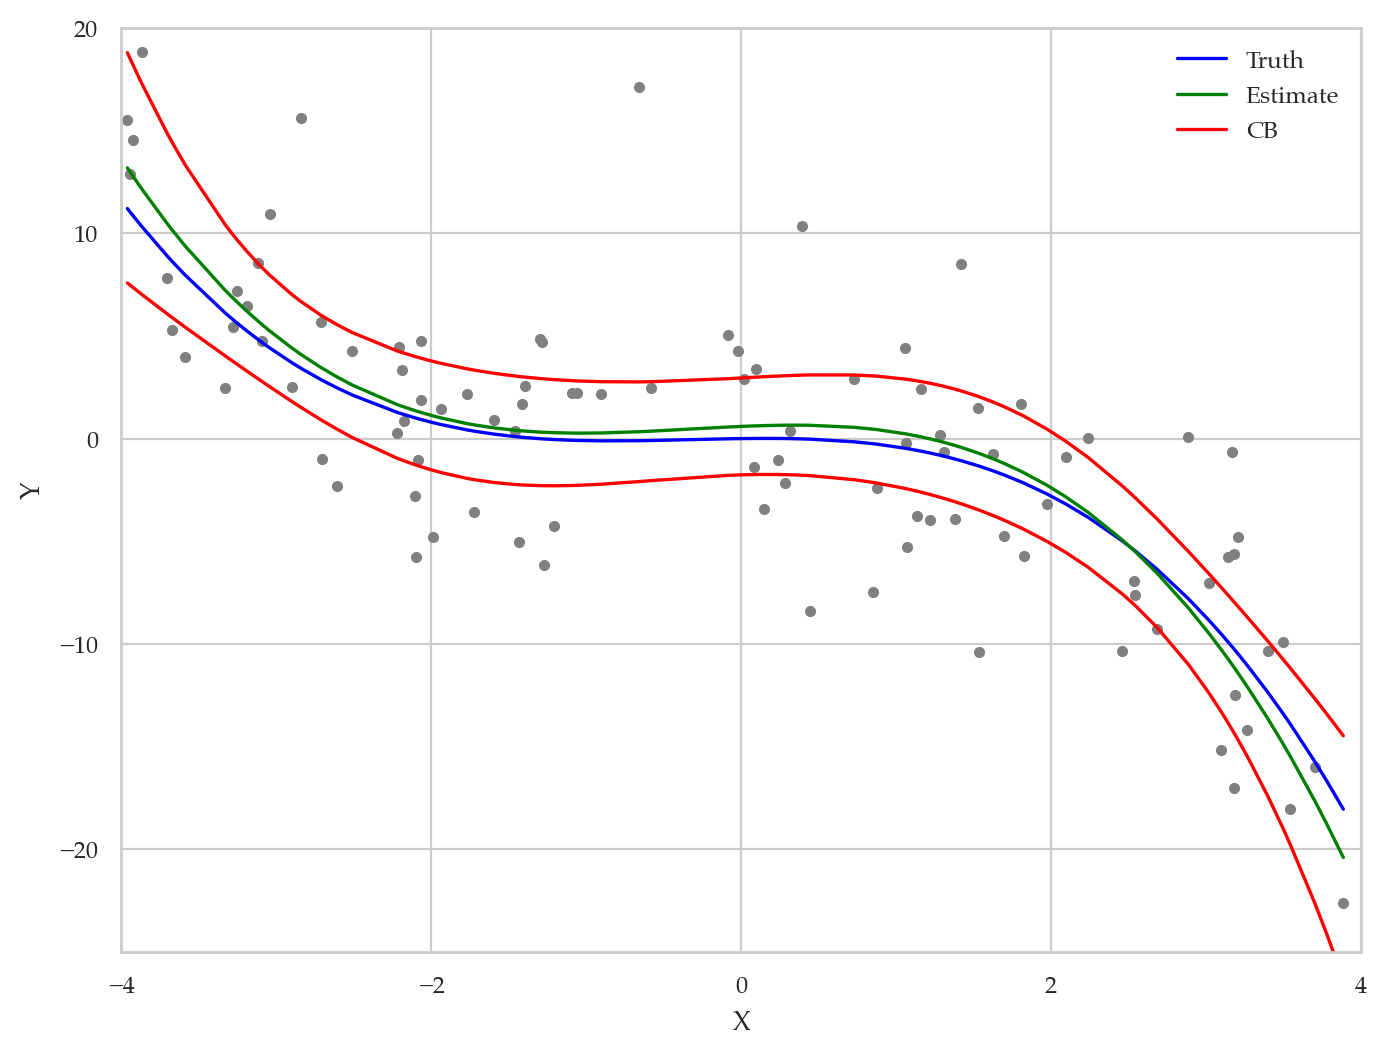

In [22]:
# via https://en.m.wikipedia.org/wiki/File:Polyreg_scheffe.svg
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 100

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,4))
X[:,1] = XV
X[:,2] = XV**2
X[:,3] = XV**3

## True coefficients.
beta = np.array([0, 0.1, -0.25, -0.25], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the Scheffe interval.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)

## The lower and upper bounds of the confidence band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D

## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
plt.plot(XV, EY, '-', color='blue', label = "Truth")
plt.plot(XV, Yhat, '-', color='green', label = "Estimate")
plt.plot(XV, LB, '-', color='red', label = "CB")
plt.plot(XV, UB, '-', color='red')
plt.legend(frameon=False)
plt.ylim([-25,20])
plt.gca().set_yticks([-20,-10,0,10,20])
plt.xlim([-4,4])
plt.gca().set_xticks([-4,-2,0,2,4])
plt.xlabel("X")
plt.ylabel("Y")

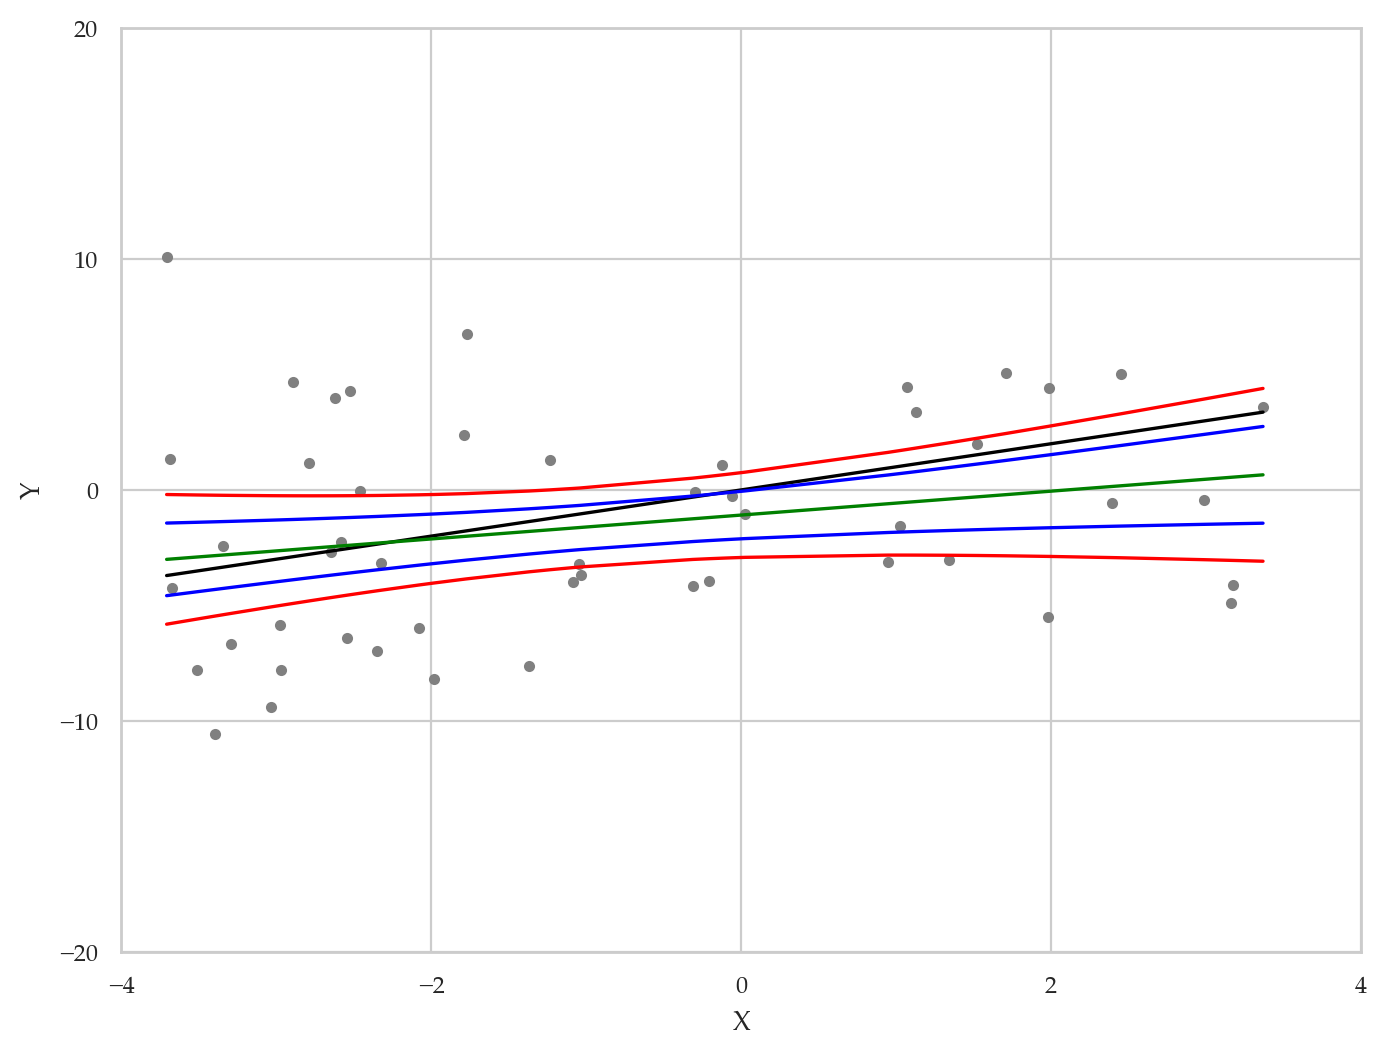

In [76]:
# via https://en.wikipedia.org/wiki/File:Regression_confidence_band.svg
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 50

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,2))
X[:,1] = XV

## True coefficients.
beta = np.array([0, 1.], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the intervals.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)

## The lower and upper bounds of the Scheffe band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D

## The lower and upper bounds of the pointwise band.
D = s*np.sqrt(2*V)
LBP,UBP = Yhat-D,Yhat+D

## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
# plt.hold(True)
a = plt.plot(XV, EY, '-', color='black')
b = plt.plot(XV, LB, '-', color='red')
plt.plot(XV, UB, '-', color='red')
c = plt.plot(XV, LBP, '-', color='blue')
plt.plot(XV, UBP, '-', color='blue')
d = plt.plot(XV, Yhat, '-', color='green')
# B = plt.legend( (a,d,b,c), ("Truth", "Estimate", "95% simultaneous CB", "95% pointwise CB") )
# B.draw_frame(False)
plt.ylim([-20,15])
plt.gca().set_yticks([-20,-10,0,10,20])
plt.xlim([-4,4])
plt.gca().set_xticks([-4,-2,0,2,4])
plt.xlabel("X")
plt.ylabel("Y");